# Capstone Project Bangkit Academy 2024 Batch 1
**Aspect-Based Sentimen Analysis (Bizzagi)**

**Using Transfer Learning with BERT for word Embedding and Neural Network Integration with CNN & LSTM**


**By : C241-AB02**


## Import Library


In [1]:
import numpy as np
import pandas as pd
import re
import string
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import logging
import torch.optim as optim
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud

from transformers import AutoTokenizer, AutoModel, AutoConfig
tokenizer = AutoTokenizer.from_pretrained("crypter70/IndoBERT-Sentiment-Analysis")
config = AutoConfig.from_pretrained("crypter70/IndoBERT-Sentiment-Analysis")
model = AutoModel.from_pretrained("crypter70/IndoBERT-Sentiment-Analysis", config=config)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

In [2]:
!pip install PySastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 1.1 MB/s eta 0:00:00


## Data Import & Understanding

In [3]:
text = pd.read_csv('https://raw.githubusercontent.com/C241-AB02-Bizzagi/Aspectra-Model-Aspect-Based-Sentiment-Analysis-System-/main/Aspectra%20Dataset.csv')

In [4]:
text.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,-1,1
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,-1,1
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1
4,"Kasir jutek. Makanan lama dateng, porsi kecil ...",0,1,-1,1,0,0,-1,1


In [5]:
print('Data terdiri dari %.f rows and %.f columns' %(text.shape[0], text.shape[1]))

Data terdiri dari 1399 rows and 9 columns


In [6]:
columns_to_count = ['y_rasa', 'c_rasa', 'y_pelayanan', 'c_pelayanan', 'y_tempat', 'c_tempat', 'y_harga', 'c_harga']
for column in columns_to_count:
    print(f"Frequencies in column {column}:")
    print(text[column].value_counts())
    print()

Frequencies in column y_rasa:
y_rasa
 0    898
-1    251
 1    250
Name: count, dtype: int64

Frequencies in column c_rasa:
c_rasa
1    751
0    648
Name: count, dtype: int64

Frequencies in column y_pelayanan:
y_pelayanan
 0    899
-1    250
 1    250
Name: count, dtype: int64

Frequencies in column c_pelayanan:
c_pelayanan
1    750
0    649
Name: count, dtype: int64

Frequencies in column y_tempat:
y_tempat
 0    895
 1    253
-1    251
Name: count, dtype: int64

Frequencies in column c_tempat:
c_tempat
1    750
0    649
Name: count, dtype: int64

Frequencies in column y_harga:
y_harga
 0    899
-1    250
 1    250
Name: count, dtype: int64

Frequencies in column c_harga:
c_harga
 1    750
 0    648
-1      1
Name: count, dtype: int64



In [7]:
text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1399 entries, 0 to 1398
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review       1399 non-null   object
 1   y_rasa       1399 non-null   int64 
 2   c_rasa       1399 non-null   int64 
 3   y_pelayanan  1399 non-null   int64 
 4   c_pelayanan  1399 non-null   int64 
 5   y_tempat     1399 non-null   int64 
 6   c_tempat     1399 non-null   int64 
 7   y_harga      1399 non-null   int64 
 8   c_harga      1399 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 98.5+ KB


## Data Preprocessing

### Checking Missing Values & Duplicates

In [8]:
text.isnull().sum().sort_values(ascending=False)

Review         0
y_rasa         0
c_rasa         0
y_pelayanan    0
c_pelayanan    0
y_tempat       0
c_tempat       0
y_harga        0
c_harga        0
dtype: int64

In [9]:
duplicate_value = text.duplicated().sum()
print('Jumlah duplicated value pada dataset review adalah : ', duplicate_value)

Jumlah duplicated value pada dataset review adalah :  1


In [10]:
text = text.drop_duplicates()
text.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,-1,1
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,-1,1
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1
4,"Kasir jutek. Makanan lama dateng, porsi kecil ...",0,1,-1,1,0,0,-1,1


### Case Folding

In [11]:
# mengubah jenis huruf menjadi huruf kecil
def lowercase(review_text):
  low = review_text.lower()
  return low

text['clean_review'] = text['Review'].apply(lambda low:lowercase(str(low)))

In [12]:
text.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya. untuk ra...
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,-1,1,"tempatnya gak nyaman, banyak nyamuk. rasa maka..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,-1,1,"gak bakal balik lagi ke sini, pelayanannya bur..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...
4,"Kasir jutek. Makanan lama dateng, porsi kecil ...",0,1,-1,1,0,0,-1,1,"kasir jutek. makanan lama dateng, porsi kecil ..."


### Cleaning text with RegEx

In [13]:
# menghapus tanda baca
def remove_punctuation(review_text, default_text=" "):
  list_punct = string.punctuation
  delete_punct = str.maketrans(list_punct,' '*len(list_punct))
  new_review = ' '.join(review_text.translate(delete_punct).split())

  return new_review

text['clean_review'] = text['clean_review'].apply(lambda punct: remove_punctuation(punct))

In [14]:
# menghapus superscript dalam ulasan yang biasa digunakan oleh pengguna dalam mengulangi kata
def remove_superscript(review_text):
  number = re.compile("["u"\U00002070"
                      u"\U000000B9"
                      u"\U000000B2-\U000000B3"
                      u"\U00002074-\U00002079"
                      u"\U0000207A-\U0000207E"
                      u"U0000200D"
                      "]+", flags=re.UNICODE)
  return number.sub(r'', review_text)

text['clean_review'] = text['clean_review'].apply(lambda num: remove_superscript(num))

In [15]:
def remove_non_clear_symbols(word):
    # Ekspresi reguler untuk mencocokkan simbol-simbol yang tidak jelas
    pattern = r'[^\w\s]'  # Mengabaikan karakter alfanumerik
    cleaned_word = re.sub(pattern, '', word)
    return cleaned_word
text['clean_review'] = text['clean_review'].apply(lambda word: remove_non_clear_symbols(word))

In [16]:
def word_repetition(review_text):
  review = re.sub(r'(.)\1+', r'\1\1', review_text)
  return review

text['clean_review'] = text['clean_review'].apply(lambda word: word_repetition(word))

In [17]:
# melakukan pembatasan kata berulang menjadi satu kali, seperti suka suka -> suka
def repetition(review_text):
  repeat = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1',review_text, flags=re.IGNORECASE)
  return repeat

text['clean_review'] = text['clean_review'].apply(lambda word: repetition(word))

In [18]:
def remove_extra_whitespaces(review_text):
  review = re.sub(r'\s+',' ', review_text)
  return review

text['clean_review'] = text['clean_review'].apply(lambda extra_spaces: remove_extra_whitespaces(extra_spaces))

In [19]:
bannedword = ['wkwk', 'wkwkw','wkwkwk','hihi','hihihii','hihihi','hehehe','hehehehe','hehe',
         'huhu','huhuu','ancok','guak','cokcok','hhmm','annya','huftt', 'nya', 'kiw', 'kiww', ' mmmmuah yummie']

re_banned_words = re.compile(r"\b(" + "|".join(bannedword) + ")\\W", re.I)

def RemoveBannedWords(toPrint):
    global re_banned_words
    return re_banned_words.sub("", toPrint)

text['clean_review'] = text['clean_review'].apply(lambda banned:RemoveBannedWords(banned))

In [20]:
text.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,-1,1,tempatnya gak nyaman banyak nyamuk rasa makana...
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,-1,1,gak bakal balik lagi ke sini pelayanannya buru...
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...
4,"Kasir jutek. Makanan lama dateng, porsi kecil ...",0,1,-1,1,0,0,-1,1,kasir jutek makanan lama dateng porsi kecil ta...


### Slang Word

In [21]:
!pip install gdown

In [22]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 76.9MB/s]


In [23]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', ' aplikasi'], ['apps ', ' aplikasi'], ['app ', ' aplikasi'], ['afordable ', ' affordable'], [

In [24]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [25]:
clean_text = []
for review in text['clean_review']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [26]:
text['clean_review'] = clean_text

Column clean_review akan digunakan untuk training data. Tahapan setelah ini hanya untuk melakukan visualisai

### Tokenize

In [27]:
def word_token(review_text):
  return word_tokenize(review_text)

In [28]:
text['clean_and_tokenized'] = text['clean_review'].apply(word_token)

In [29]:
text.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[memang, cukup, luas, dan, sepi, tempatnya, un..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,-1,1,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempatnya, tidak, nyaman, banyak, nyamuk, ras..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,-1,1,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, bakal, balik, lagi, ke, sini, pelayana..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harganya, terlalu, mahal, untuk, rasa, yang, ..."
4,"Kasir jutek. Makanan lama dateng, porsi kecil ...",0,1,-1,1,0,0,-1,1,kasir jutek makanan lama datang porsi kecil ta...,"[kasir, jutek, makanan, lama, datang, porsi, k..."


### Stopword

In [30]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('popular')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data] 

True

In [31]:
# menampilkan kata stopwords bahasa indonesia
indo_stopwords = stopwords.words('indonesian')

# menghitung jumlah kata stopwords bahasa indonesia
print('Length of Indonesian stopwords:', len(indo_stopwords))
print(indo_stopwords)

Length of Indonesian stopwords: 758
['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'ber

In [32]:
stopwords_to_remove = ['agak','kurang', 'biasa', 'biasanya', 'cukup', 'cukuplah', 'hanya', 'harus', 'kembali', 'lagi', 'lama', 'lamanya','lebih','makin', 'padahal', 'sangat', 'satu', 'seenaknya', 'semua','' ,'tempat', 'dua', 'empat', 'setempat', 'rasa', 'merasa', 'terasa','rasanya', 'setidaknya', 'tidak', 'tidakkah', 'tidaklah', 'sekurangnya', 'sedikit', 'sedikitnya', 'umum', 'umumnya', 'waktu' ]

# Menghapus kata-kata tersebut dari daftar stopwords
modified_stopwords = [word for word in indo_stopwords if word not in stopwords_to_remove]

# Menampilkan daftar stopwords yang telah dimodifikasi
print('Length of Modified Indonesian stopwords:', len(modified_stopwords))
print(modified_stopwords)

Length of Modified Indonesian stopwords: 721
['ada', 'adalah', 'adanya', 'adapun', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'be

In [33]:
def remove_stopwords(review_text, modified_stopwords):
  tokenize = []
  for token in review_text:
    if token not in modified_stopwords:
      tokenize.append(token)

  return tokenize

text['clean_and_tokenized'] = text['clean_and_tokenized'].apply(lambda x: remove_stopwords(x, modified_stopwords))

### Stemming

In [34]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [35]:
# Fungsi untuk melakukan stemming pada setiap token dalam daftar token
def stem_tokens(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Menerapkan fungsi stem_tokens() ke kolom 'clean_and_tokenized' dan menyimpan hasilnya dalam kolom 'final_text'
text['clean_and_tokenized'] = text['clean_and_tokenized'].apply(lambda tokens: stem_tokens(tokens))

### Visualisasi

In [36]:
from collections import Counter

# Membuat string yang berisi semua token dari seluruh baris dalam kolom 'clean_and_tokenize'
all_tokens_text = ' '.join(text['clean_and_tokenized'].sum())

# Membuat objek Counter untuk menghitung kemunculan setiap kata dalam teks
word_counts = Counter(all_tokens_text.split())

# Menampilkan 10 kata dengan jumlah kemunculan terbanyak
top_words = word_counts.most_common(10)
print("Top 10 kata dengan jumlah kemunculan terbanyak:")
for word, count in top_words:
    print(f"{word}: {count}")


Top 10 kata dengan jumlah kemunculan terbanyak:
makan: 743
tidak: 700
harga: 660
tempat: 654
layan: 641
rasa: 360
enak: 347
sangat: 329
kurang: 249
nyaman: 244


In [37]:
from collections import Counter

# Membuat string yang berisi semua token dari seluruh baris dalam kolom 'clean_and_tokenized'
all_tokens_text = ' '.join(sum(text['clean_and_tokenized'], []))

# Membuat objek Counter untuk menghitung kemunculan setiap kata dalam teks
word_counts = Counter(all_tokens_text.split())

# Menampilkan 10 kata dengan jumlah kemunculan terbanyak
top_words = word_counts.most_common(10)

# Menghapus kemunculan kedua kata "tidak"
tidak_count = 0
filtered_top_words = []
for word, count in top_words:
    if word == 'tidak':
        tidak_count += 1
        if tidak_count == 2:
            continue
    filtered_top_words.append((word, count))

print("Top 10 kata dengan jumlah kemunculan terbanyak:")
for word, count in filtered_top_words:
    print(f"{word}: {count}")


Top 10 kata dengan jumlah kemunculan terbanyak:
makan: 743
tidak: 700
harga: 660
tempat: 654
layan: 641
rasa: 360
enak: 347
sangat: 329
kurang: 249
nyaman: 244


<ipython-input-38-8606b4965c73>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=words, y=counts, palette='autumn')


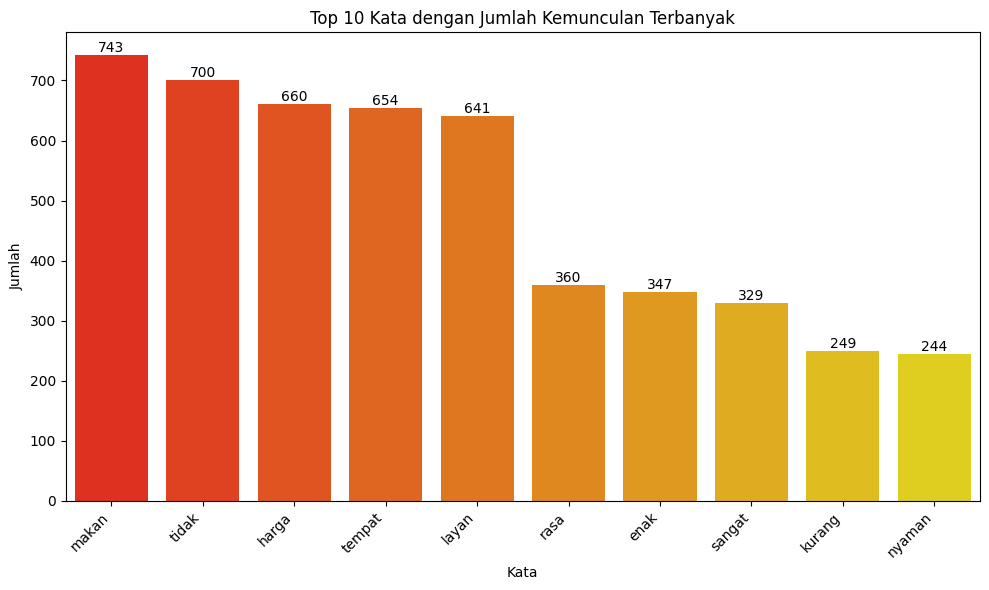

In [38]:
# Ambil data dari top_words
words = [word for word, _ in top_words]
counts = [count for _, count in top_words]

# Buat plot menggunakan seaborn
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=words, y=counts, palette='autumn')
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.title('Top 10 Kata dengan Jumlah Kemunculan Terbanyak')
plt.xticks(rotation=45, ha='right')

# Tambahkan anotasi ke setiap bar
for bar, count in zip(bars.patches, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{count}', va='bottom', ha='center')

plt.tight_layout()
plt.show()

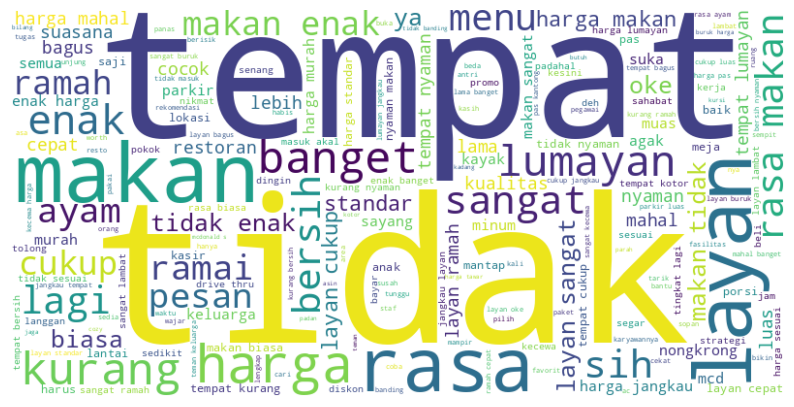

In [39]:
# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens_text)

# Menampilkan wordcloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [40]:
text.head()

,Review,y_rasa,c_rasa,y_pelayanan,c_pelayanan,y_tempat,c_tempat,y_harga,c_harga,clean_review,clean_and_tokenized
0,memang cukup luas dan sepi tempatnya. untuk ra...,0,1,0,0,0,1,0,0,memang cukup luas dan sepi tempatnya untuk ras...,"[cukup, luas, sepi, tempat, rasa, makan, turut..."
1,"Tempatnya gak nyaman, banyak nyamuk. Rasa maka...",0,1,0,0,-1,1,-1,1,tempatnya tidak nyaman banyak nyamuk rasa maka...,"[tempat, tidak, nyaman, nyamuk, rasa, makan, b..."
2,"Gak bakal balik lagi ke sini, pelayanannya bur...",-1,1,-1,1,0,0,-1,1,tidak bakal balik lagi ke sini pelayanannya bu...,"[tidak, lagi, layan, buruk, makan, dingin, har..."
3,Harganya terlalu mahal untuk rasa yang mengece...,-1,1,0,0,0,0,-1,1,harganya terlalu mahal untuk rasa yang mengece...,"[harga, mahal, rasa, kecewa]"
4,"Kasir jutek. Makanan lama dateng, porsi kecil ...",0,1,-1,1,0,0,-1,1,kasir jutek makanan lama datang porsi kecil ta...,"[kasir, jutek, makan, lama, porsi, overpriced,..."


## Data Loader

In [27]:
text_data = text['clean_review'].values
output_sentiment = text[['y_rasa', 'y_pelayanan', 'y_tempat', 'y_harga']].values
output_confidence = np.abs(text[['c_rasa', 'c_pelayanan', 'c_tempat', 'c_harga']].values)

# Split the data
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
    text_data, output_sentiment, output_confidence, test_size=0.2, random_state=42)

In [28]:
class CustomDataset(Dataset):
    def __init__(self, texts, sentiment_labels, confidence_labels, tokenizer, max_length):
        self.texts = texts
        self.sentiment_labels = sentiment_labels
        self.confidence_labels = confidence_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        sentiment_label = self.sentiment_labels[idx]
        confidence_label = self.confidence_labels[idx]

        inputs = self.tokenizer(text,
                                add_special_tokens=True,
                                max_length=self.max_length,
                                padding='max_length',  # Updated argument
                                return_token_type_ids=False,
                                return_attention_mask=True,
                                truncation=True,
                                return_tensors='pt')

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'sentiment_labels': torch.tensor(sentiment_label, dtype=torch.float32),
            'confidence_labels': torch.tensor(confidence_label, dtype=torch.float32)
        }

In [29]:
train_dataset = CustomDataset(X_train, y_train, c_train, tokenizer, 64)
test_dataset = CustomDataset(X_test, y_test, c_test, tokenizer, 64)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Development

### Word Embedding

In [30]:
class BertEmbedding(nn.Module):
    def __init__(self, model):
        super(BertEmbedding, self).__init__()
        self.bert = model
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state.mean(dim=1)
        pooled_output = self.dropout(pooled_output)
        return pooled_output

embedding_model = BertEmbedding(model)

### Attention Layer

In [31]:
class Attention(nn.Module):
    def __init__(self, attention_size):
        super(Attention, self).__init__()
        self.attention_weights = nn.Linear(attention_size, 1, bias=False)

    def forward(self, lstm_output):
        attention_scores = self.attention_weights(lstm_output).squeeze(-1)
        attention_weights = torch.softmax(attention_scores, dim=1)
        weighted_sum = torch.sum(lstm_output * attention_weights.unsqueeze(-1), dim=1)
        return weighted_sum, attention_weights

### Final Model

In [32]:
class ABSA_LSTM_CNN(nn.Module):
    def __init__(self, embedding_model, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence):
        super(ABSA_LSTM_CNN, self).__init__()
        self.embedding_model = embedding_model
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=256, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(256, hidden_size, num_layers, batch_first=True, dropout=0.2, bidirectional=True)
        self.attention = Attention(hidden_size * 2)

        self.fc1 = nn.Linear(hidden_size * 2, 128)
        self.dropout1 = nn.Dropout(p=0.2)

        self.fc_sentiment = nn.Linear(128, num_classes_sentiment)
        self.fc_confidence = nn.Linear(128, num_classes_confidence)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        embeddings = self.embedding_model(input_ids, attention_mask)
        embeddings = embeddings.unsqueeze(1).repeat(1, input_ids.size(1), 1)

        x = embeddings.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(input_ids.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(input_ids.device)
        out, _ = self.lstm(x, (h0, c0))

        attn_output, _ = self.attention(out)

        out = self.fc1(attn_output)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.relu(out)

        sentiment = self.fc_sentiment(out)
        sentiment = self.tanh(sentiment)

        confidence = self.fc_confidence(out)
        confidence = self.sigmoid(confidence)

        return sentiment, confidence

In [33]:
input_size = 768
hidden_size = 256
num_layers = 1
num_classes_sentiment = 4
num_classes_confidence = 4

absa_model = ABSA_LSTM_CNN(embedding_model, input_size, hidden_size, num_layers, num_classes_sentiment, num_classes_confidence)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [34]:
print(absa_model)

ABSA_LSTM_CNN(
  (embedding_model): BertEmbedding(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(50000, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bi

## Model Training

### Accuray Function

In [35]:
def calculate_accuracy(predictions, targets):
    if len(predictions) != len(targets):
        raise ValueError("Length of predictions and targets must be the same")

    num_correct = sum(p == t for p, t in zip(predictions, targets))
    accuracy = num_correct / len(predictions)

    return accuracy

### Metrics Function

In [36]:
def calculate_metrics(predictions, targets, average='macro'):
    precision = precision_score(targets, predictions, average=average)
    recall = recall_score(targets, predictions, average=average)
    f1 = f1_score(targets, predictions, average=average)
    return precision, recall, f1

### Training and Evaluation

In [37]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
absa_model.to(device)

criterion_sentiment = nn.MSELoss()
criterion_confidence = nn.MSELoss()
optimizer = optim.Adam(absa_model.parameters(), lr=2e-5)

epochs = 100

train_losses = []
train_sentiment_accuracies = []
train_confidence_accuracies = []
test_losses = []
test_sentiment_accuracies = []
test_confidence_accuracies = []

for epoch in range(epochs):
    # Training
    absa_model.train()
    train_loss = 0.0
    total_sentiment_accuracy = 0.0
    total_confidence_accuracy = 0.0
    total_batches = 0

    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiment_labels = batch['sentiment_labels'].to(device)
        confidence_labels = batch['confidence_labels'].float().to(device)

        optimizer.zero_grad()
        sentiment_output, confidence_output = absa_model(input_ids, attention_mask)

        loss_sentiment = criterion_sentiment(sentiment_output, sentiment_labels)
        loss_confidence = criterion_confidence(confidence_output, confidence_labels)
        loss = loss_sentiment + loss_confidence

        sentiment_preds = torch.round(sentiment_output.detach())
        confidence_preds = torch.round(confidence_output.detach())

        sentiment_preds_np = sentiment_preds.cpu().numpy()
        confidence_preds_np = confidence_preds.cpu().numpy()
        sentiment_labels_np = sentiment_labels.cpu().numpy()
        confidence_labels_np = confidence_labels.cpu().numpy()

        accuracy_sentiment = calculate_accuracy(sentiment_preds_np.flatten(), sentiment_labels_np.flatten())
        accuracy_confidence = calculate_accuracy(confidence_preds_np.flatten(), confidence_labels_np.flatten())

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_sentiment_accuracy += accuracy_sentiment
        total_confidence_accuracy += accuracy_confidence
        total_batches += 1

    avg_loss = train_loss / total_batches
    avg_sentiment_accuracy = total_sentiment_accuracy / total_batches
    avg_confidence_accuracy = total_confidence_accuracy / total_batches

    train_losses.append(avg_loss)
    train_sentiment_accuracies.append(avg_sentiment_accuracy)
    train_confidence_accuracies.append(avg_confidence_accuracy)

    print(f'Epoch [{epoch+1}/{epochs}]:\n '
          f'Loss: {avg_loss:.8f}, '
          f'Sentiment Accuracy: {avg_sentiment_accuracy:.8f}, '
          f'Confidence Accuracy: {avg_confidence_accuracy:.8f}')

    # Evaluation
    absa_model.eval()
    test_loss = 0.0
    total_sentiment_accuracy = 0.0
    total_confidence_accuracy = 0.0
    total_sentiment_precision = 0.0
    total_sentiment_recall = 0.0
    total_sentiment_f1 = 0.0
    total_confidence_precision = 0.0
    total_confidence_recall = 0.0
    total_confidence_f1 = 0.0
    total_batches = 0

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiment_labels = batch['sentiment_labels'].to(device)
            confidence_labels = batch['confidence_labels'].to(device)

            sentiment_output, confidence_output = absa_model(input_ids, attention_mask)

            loss_sentiment = criterion_sentiment(sentiment_output, sentiment_labels)
            loss_confidence = criterion_confidence(confidence_output, confidence_labels)
            total_loss_batch = loss_sentiment + loss_confidence

            sentiment_preds = torch.round(sentiment_output).cpu().numpy()
            confidence_preds = torch.round(confidence_output).cpu().numpy()
            output_sentiment_batch_np = sentiment_labels.cpu().numpy()
            output_confidence_batch_np = confidence_labels.cpu().numpy()

            accuracy_sentiment = calculate_accuracy(sentiment_preds.flatten(), output_sentiment_batch_np.flatten())
            accuracy_confidence = calculate_accuracy(confidence_preds.flatten(), output_confidence_batch_np.flatten())

            precision_sentiment, recall_sentiment, f1_sentiment = calculate_metrics(sentiment_preds.flatten(), output_sentiment_batch_np.flatten())
            precision_confidence, recall_confidence, f1_confidence = calculate_metrics(confidence_preds.flatten(), output_confidence_batch_np.flatten())

            test_loss += total_loss_batch.item()
            total_sentiment_accuracy += accuracy_sentiment
            total_confidence_accuracy += accuracy_confidence
            total_sentiment_precision += precision_sentiment
            total_sentiment_recall += recall_sentiment
            total_sentiment_f1 += f1_sentiment
            total_confidence_precision += precision_confidence
            total_confidence_recall += recall_confidence
            total_confidence_f1 += f1_confidence
            total_batches += 1

    avg_test_loss = test_loss / total_batches
    avg_sentiment_metrics = {
        "accuracy": total_sentiment_accuracy / total_batches,
        "precision": total_sentiment_precision / total_batches,
        "recall": total_sentiment_recall / total_batches,
        "f1": total_sentiment_f1 / total_batches
    }
    avg_confidence_metrics = {
        "accuracy": total_confidence_accuracy / total_batches,
        "precision": total_confidence_precision / total_batches,
        "recall": total_confidence_recall / total_batches,
        "f1": total_confidence_f1 / total_batches
    }

    test_losses.append(avg_test_loss)
    test_sentiment_accuracies.append(avg_sentiment_metrics["accuracy"])
    test_confidence_accuracies.append(avg_confidence_metrics["accuracy"])

    print(f'Test Loss: {avg_test_loss:.8f}, '
          f'Test Sentiment Accuracy: {avg_sentiment_metrics["accuracy"]:.8f}, '
          f'Test Confidence Accuracy: {avg_confidence_metrics["accuracy"]:.8f}')


Epoch [1/100]:
 Loss: 0.55448863, Sentiment Accuracy: 0.64093750, Confidence Accuracy: 0.52241071


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Test Loss: 0.51195043, Test Sentiment Accuracy: 0.64438657, Test Confidence Accuracy: 0.54050926
Epoch [2/100]:
 Loss: 0.50373740, Sentiment Accuracy: 0.64311012, Confidence Accuracy: 0.57456845


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

Test Loss: 0.48232998, Test Sentiment Accuracy: 0.65480324, Test Confidence Accuracy: 0.58478009
Epoch [3/100]:
 Loss: 0.46784494, Sentiment Accuracy: 0.67544643, Confidence Accuracy: 0.62433036


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.43527306, Test Sentiment Accuracy: 0.71006944, Test Confidence Accuracy: 0.70515046
Epoch [4/100]:
 Loss: 0.40686691, Sentiment Accuracy: 0.75495536, Confidence Accuracy: 0.72388393
Test Loss: 0.39057321, Test Sentiment Accuracy: 0.80613426, Test Confidence Accuracy: 0.76388889
Epoch [5/100]:
 Loss: 0.34515854, Sentiment Accuracy: 0.83433036, Confidence Accuracy: 0.78221726
Test Loss: 0.33666631, Test Sentiment Accuracy: 0.84606481, Test Confidence Accuracy: 0.83420139
Epoch [6/100]:
 Loss: 0.28873799, Sentiment Accuracy: 0.89132440, Confidence Accuracy: 0.83830357
Test Loss: 0.29431722, Test Sentiment Accuracy: 0.86950231, Test Confidence Accuracy: 0.85648148
Epoch [7/100]:
 Loss: 0.24118999, Sentiment Accuracy: 0.92933036, Confidence Accuracy: 0.87880952
Test Loss: 0.25466538, Test Sentiment Accuracy: 0.89380787, Test Confidence Accuracy: 0.88454861
Epoch [8/100]:
 Loss: 0.20360464, Sentiment Accuracy: 0.95510417, Confidence Accuracy: 0.91297619
Test Loss: 0.23347735, Te

## Prediction

In [40]:
def predict_reviews(review_data, max_sequence_length, model, tokenizer):
    model.eval()  # Set model to evaluation mode

    for review_text in review_data:
        # Tokenize the review text
        encoded_input = tokenizer(review_text, padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors='pt')

        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)

        with torch.no_grad():
            sentiment_pred, confidence_pred = model(input_ids, attention_mask)

        # Post-process prediction
        sentiment_pred = sentiment_pred.cpu().numpy()
        confidence_pred = confidence_pred.cpu().numpy()

        sentiment_pred = np.round(sentiment_pred).astype(int)
        confidence_pred = np.round(confidence_pred).astype(int)

        # Print prediction
        print("Review:", review_text)
        print("[Rasa, Pelayanan, Tempat, Harga]")
        print("Sentiment prediction:", sentiment_pred[0])
        print("Confidence prediction:", confidence_pred[0])
        print("")


review_data = [
    "hahahaha apaan rasa makanan kaya gini mana karyawan jutek banget",
    "enak sih enak tapi cuy ini tuh kemahalan banget harganya. kapok juga dompet gue",
    "rasanya lumayan",
    'makanannya standar si biasa aja',
    'tempatnya cukup nyaman, harganya juga murah untuk porsi yang besar',
    'rasanya biasa aja padahal harganya udah tergolong mahal',
    'makanannya standar si, tapi harganya murah banget, pelayanannya juga memuaskan'
]

max_sequence_length = 64

# Assuming custom_model and tokenizer are already defined and loaded as per your provided code
predict_reviews(review_data, max_sequence_length, absa_model, tokenizer)


Review: hahahaha apaan rasa makanan kaya gini mana karyawan jutek banget
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [-1 -1  0  0]
Confidence prediction: [1 1 0 0]

Review: enak sih enak tapi cuy ini tuh kemahalan banget harganya. kapok juga dompet gue
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [ 1  0  0 -1]
Confidence prediction: [1 0 0 1]

Review: rasanya lumayan
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [0 0 0 0]
Confidence prediction: [1 0 0 0]

Review: makanannya standar si biasa aja
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [0 0 0 0]
Confidence prediction: [1 0 0 0]

Review: tempatnya cukup nyaman, harganya juga murah untuk porsi yang besar
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [0 0 0 1]
Confidence prediction: [0 0 1 1]

Review: rasanya biasa aja padahal harganya udah tergolong mahal
[Rasa, Pelayanan, Tempat, Harga]
Sentiment prediction: [ 0  0  0 -1]
Confidence prediction: [1 0 0 1]

Review: makanannya standar si,

## Visualisasi Metrics

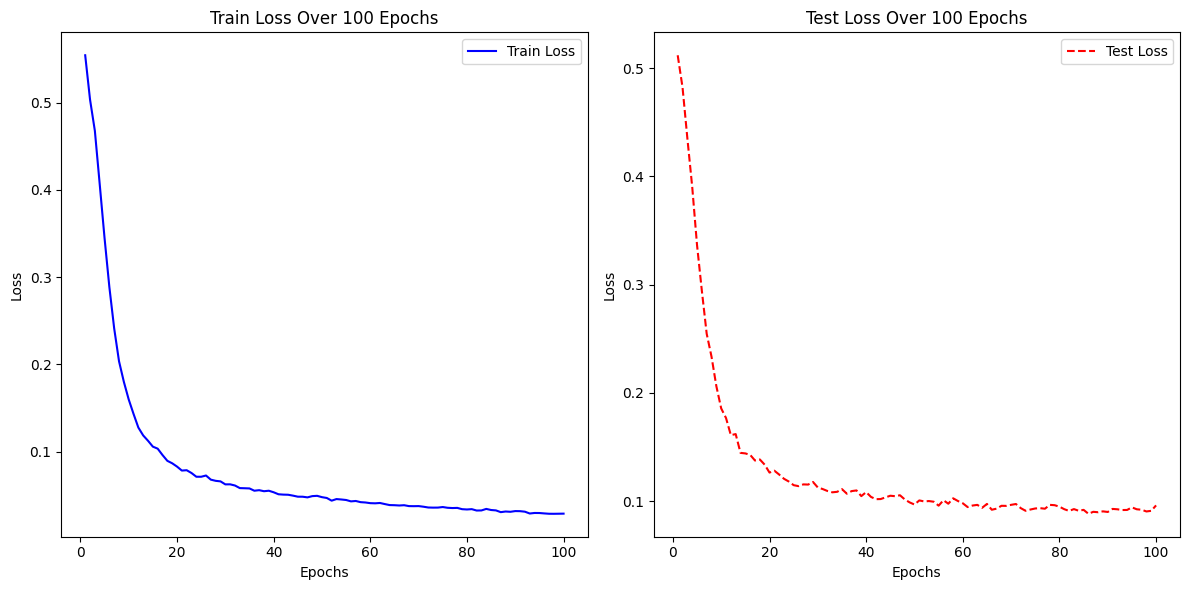

In [41]:
epochs_range = range(1, epochs + 1)

# Plot train loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over 100 Epochs')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_losses, label='Test Loss', color='red',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss Over 100 Epochs')
plt.legend()
plt.tight_layout()
plt.show()

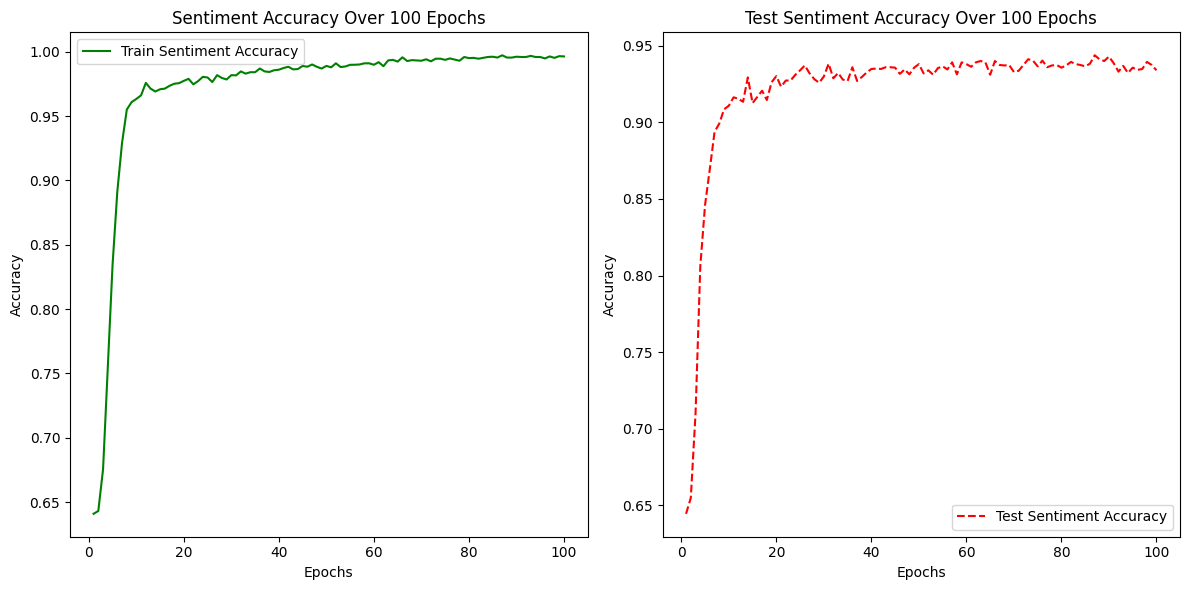

In [42]:
# Plot train and test sentiment accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_sentiment_accuracies,color='green', label='Train Sentiment Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Sentiment Accuracy Over 100 Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_sentiment_accuracies, label='Test Sentiment Accuracy',color='red', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Sentiment Accuracy Over 100 Epochs')
plt.legend()

plt.tight_layout()
plt.show()

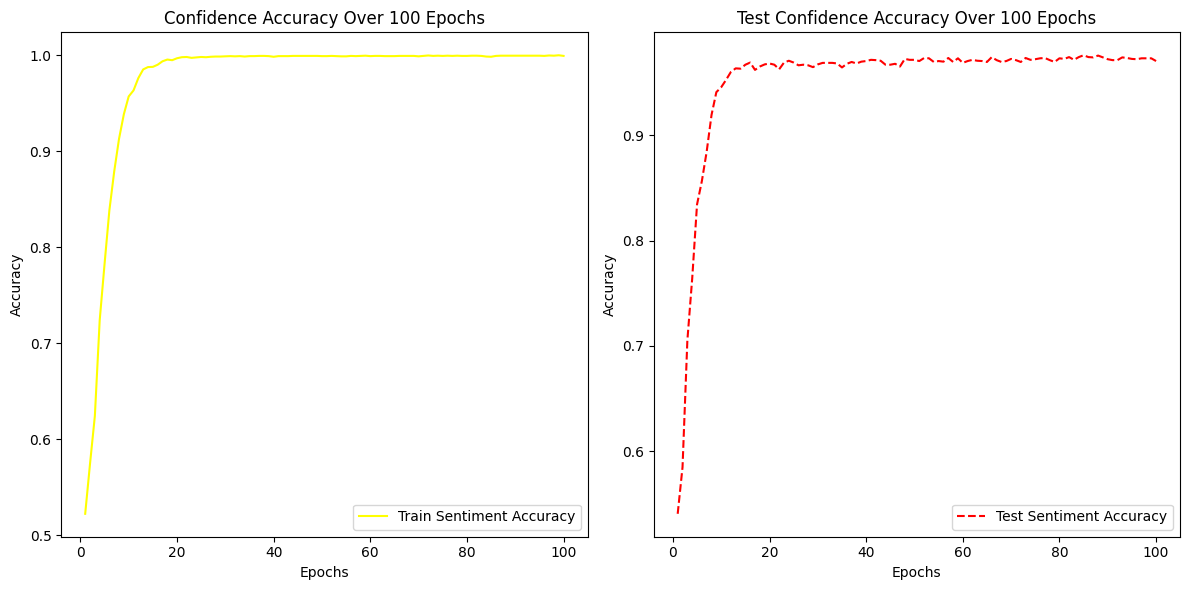

In [43]:
# Plot train and test confidence accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_confidence_accuracies,color='yellow', label='Train Sentiment Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Confidence Accuracy Over 100 Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_confidence_accuracies, color='red', label='Test Sentiment Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Confidence Accuracy Over 100 Epochs')
plt.legend()

plt.tight_layout()
plt.show()

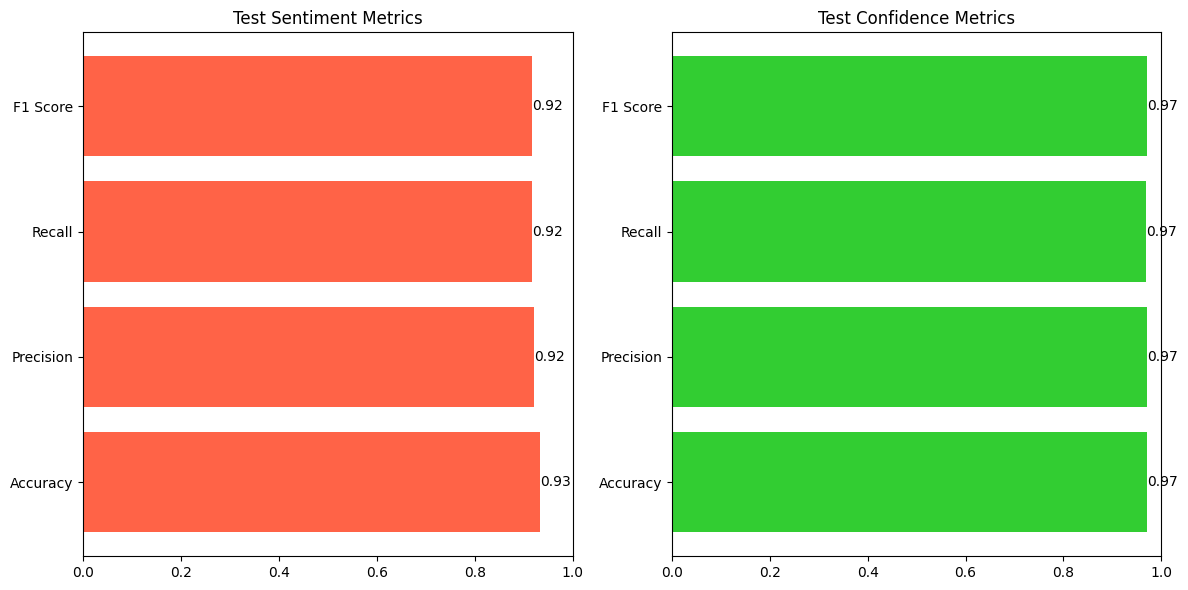

In [44]:
test_metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
sentiment_metrics_values = [avg_sentiment_metrics["accuracy"], avg_sentiment_metrics["precision"], avg_sentiment_metrics["recall"], avg_sentiment_metrics["f1"]]
confidence_metrics_values = [avg_confidence_metrics["accuracy"], avg_confidence_metrics["precision"], avg_confidence_metrics["recall"], avg_confidence_metrics["f1"]]

# Palet warna pastel
sentiment_color = '#FF6347'
confidence_color = '#32CD32'

# Plot test metrics
plt.figure(figsize=(12, 6))

# Plot test sentiment metrics
plt.subplot(1, 2, 1)
plt.barh(test_metrics_names, sentiment_metrics_values, color=sentiment_color)
plt.xlim(0, 1)
plt.title('Test Sentiment Metrics')
for i, v in enumerate(sentiment_metrics_values):
    plt.text(v, i, f'{v:.2f}', ha='left', va='center')

# Plot test confidence metrics
plt.subplot(1, 2, 2)
plt.barh(test_metrics_names, confidence_metrics_values, color=confidence_color)
plt.xlim(0, 1)
plt.title('Test Confidence Metrics')
for i, v in enumerate(confidence_metrics_values):
    plt.text(v, i, f'{v:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

## Save Model

In [ ]:
path = "model-absa.pth"

# Simpan model
torch.save(absa_model, path)